In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sktime.forecasting.theta               import ThetaForecaster
from sktime.forecasting.fbprophet           import Prophet
from sktime.forecasting.base                import ForecastingHorizon

from sklearn                import preprocessing 
from sklearn.metrics        import mean_squared_error,mean_absolute_percentage_error,mean_absolute_error
from sklearn.neighbors      import KNeighborsRegressor
from sklearn.linear_model   import Lasso

from sktime.forecasting.arima               import ARIMA
from sktime.forecasting.base                import ForecastingHorizon
from sktime.forecasting.trend               import PolynomialTrendForecaster,TrendForecaster
from sktime.forecasting.exp_smoothing       import ExponentialSmoothing
from sktime.forecasting.statsforecast       import StatsForecastAutoARIMA
from sktime.forecasting.compose             import TransformedTargetForecaster
from sktime.transformations.series.detrend  import Deseasonalizer,Detrender
from sktime.transformations.series.difference import Differencer
from sktime.transformations.series.lag      import Lag


from sktime.forecasting.compose import AutoEnsembleForecaster
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_percentage_error

from sktime.utils.plotting import plot_series
from sktime.forecasting.compose import RecursiveTabularRegressionForecaster
from sktime.transformations.compose import YtoX, Id, FeatureUnion
from sktime.transformations.series.summarize import WindowSummarizer
from sktime.transformations.series.date import DateTimeFeatures
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.compose import ForecastingPipeline
from sktime.forecasting.compose import make_reduction

from sktime.datasets import load_airline
import warnings

(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

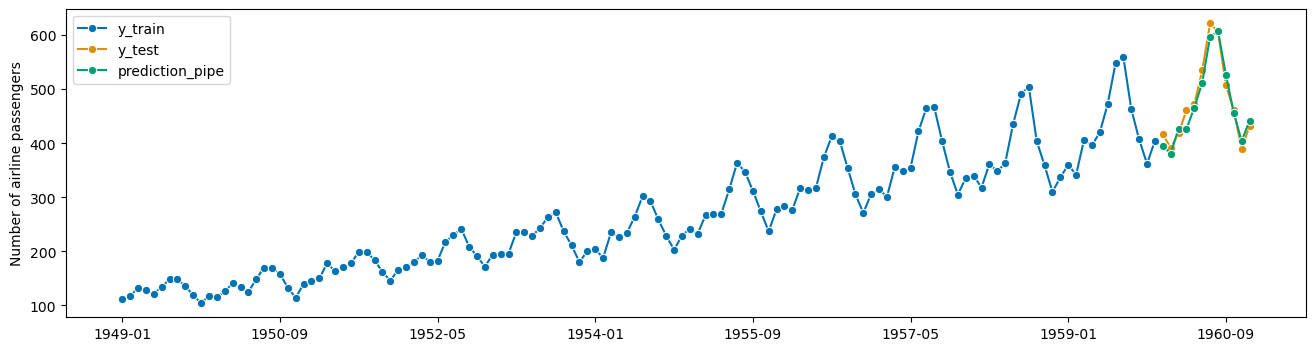

In [2]:
warnings.filterwarnings("ignore")

y = load_airline()
split = len(y)-12
y_train, y_test = y.iloc[:split], y.iloc[split:]

fh = ForecastingHorizon(y_test.index, is_relative=False)
summary_window = 6
autoregressive_features = 12

kwargs = {
        "lag_feature": {
            "lag": [1,2],
            "mean": [[1, summary_window]],
            "std": [[1, summary_window]],
        }
    }

f = RecursiveTabularRegressionForecaster(estimator=Ridge(random_state=42),window_length=autoregressive_features)

pipe = ForecastingPipeline(
        steps=[
            ("ytox",YtoX()), #put Id() if there is extra X we want to use. YtoX() moves y to X
            ("transformer",WindowSummarizer(**kwargs)), #should create 4 features
            ("transformer",DateTimeFeatures(ts_freq="M", feature_scope="minimal")), #creates 2 features
            ("forecaster",f),
        ]
    )

pipe.fit(y_train)
prediction=pipe.predict(fh=fh)
plot_series(y_train,y_test,prediction,labels=["y_train", "y_test","prediction_pipe"])


In [3]:
pipe.get_fitted_params()

{'forecaster': RecursiveTabularRegressionForecaster(estimator=Ridge(random_state=42),
                                      window_length=12),
 'steps': [('ytox', YtoX()),
  ('transformer_1',
   WindowSummarizer(lag_feature={'lag': [1, 2], 'mean': [[1, 6]], 'std': [[1, 6]]})),
  ('transformer_2', DateTimeFeatures(ts_freq='M')),
  ('forecaster',
   RecursiveTabularRegressionForecaster(estimator=Ridge(random_state=42),
                                        window_length=12))],
 'ytox': YtoX(),
 'transformer_1': WindowSummarizer(lag_feature={'lag': [1, 2], 'mean': [[1, 6]], 'std': [[1, 6]]}),
 'transformer_2': DateTimeFeatures(ts_freq='M'),
 'forecaster__estimator': Ridge(random_state=42),
 'forecaster__transformers': None,
 'forecaster__window_length': 12,
 'forecaster__estimator__coef': array([ 0.49382748,  0.44323402, -0.37581343,  0.36208357, -0.36569087,
         0.32069422, -0.34500727,  0.32823832, -0.27148087,  0.25685604,
        -0.34348333,  0.53894735]),
 'forecaster__estima

### Same story! The model does not extend to the extra features. This is not working correctly. Use darts for this.